# MNIST Dataset

MNIST is a subset of a larger set available from NIST (it's copied from http://yann.lecun.com/exdb/mnist/)

### Content
The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. .

### Four files are available:
* train-images-idx3-ubyte.gz: training set images (9912422 bytes)
* train-labels-idx1-ubyte.gz: training set labels (28881 bytes)
* t10k-images-idx3-ubyte.gz: test set images (1648877 bytes)
* t10k-labels-idx1-ubyte.gz: test set labels (4542 bytes)


### Acknowledgements
* Yann LeCun, Courant Institute, NYU
* Corinna Cortes, Google Labs, New York
* Christopher J.C. Burges, Microsoft Research, Redmond

In [1]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.datasets import mnist
from itertools import product
from tensorflow.keras import backend as K

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0].name}")
else:
    print("No GPU found. TensorFlow is running on the CPU.")

Num GPUs Available:  1
TensorFlow is using GPU: /physical_device:GPU:0


In [3]:
# Load and Scale
(X_train_original, y_train_original), (X_test, y_test) = mnist.load_data()
(X_train_original, y_train_original), (X_test, y_test) = (X_train_original/255, y_train_original), (X_test/255, y_test)

In [4]:
print('MNIST Dataset Shape:')
print('X_train: ' + str(X_train_original.shape))
print('Y_train: ' + str(y_train_original.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

MNIST Dataset Shape:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


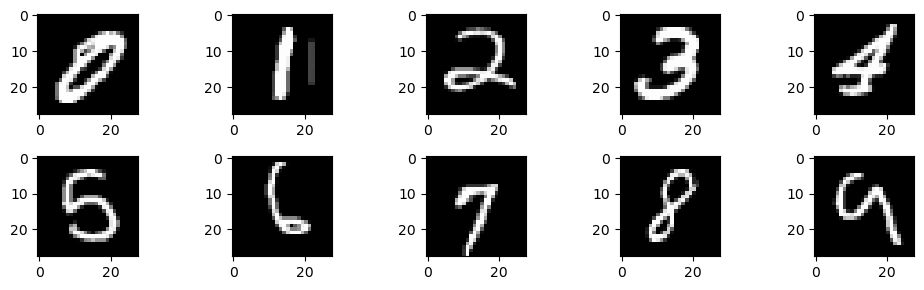

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 3))

for i, ax in enumerate(axes.flat):
    image = X_train_original[np.random.choice(np.where(y_train_original==i)[0])]
    fig = plt.figure
    ax.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

# Convolutional Neural Network

In [6]:
X_train_shaped = X_train_original.reshape(-1, X_train_original.shape[1], X_train_original.shape[2], 1)
X_test_shaped = X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1)

In [7]:
X_train_shaped = tf.cast(X_train_shaped, tf.float32)
X_test_shaped = tf.cast(X_test_shaped, tf.float32)

In [8]:
X_train_shaped.shape

TensorShape([60000, 28, 28, 1])

In [9]:
glorot_initializer = tf.initializers.GlorotUniform(seed=42)
sample_filter = tf.Variable(glorot_initializer([2, 2, 1, 16]), dtype=tf.float32)
filter_bias = tf.Variable(tf.zeros([16]), dtype=tf.float32)
sample_image = X_train_shaped[0]

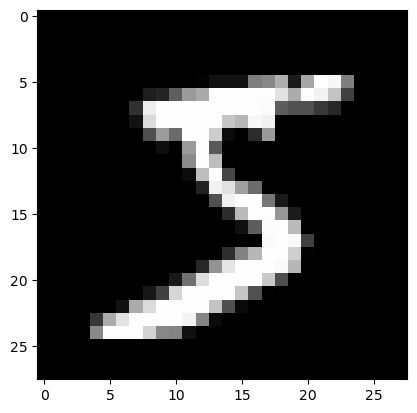

In [10]:
plt.imshow(sample_image, cmap="grey")
plt.show()

In [11]:
conv_output = tf.nn.conv2d(
    input=tf.expand_dims(sample_image, axis=0),
    filters=sample_filter,
    strides=[1, 1, 1, 1],
    padding="SAME",
    dilations=[1]
)

conv_output_with_bias = tf.nn.bias_add(conv_output, filter_bias)
activation_output = tf.nn.relu(conv_output_with_bias)

maxpooled_output = tf.nn.max_pool2d(activation_output,
                 ksize=(2, 2),
                 strides=(2, 2),
                 padding="SAME")

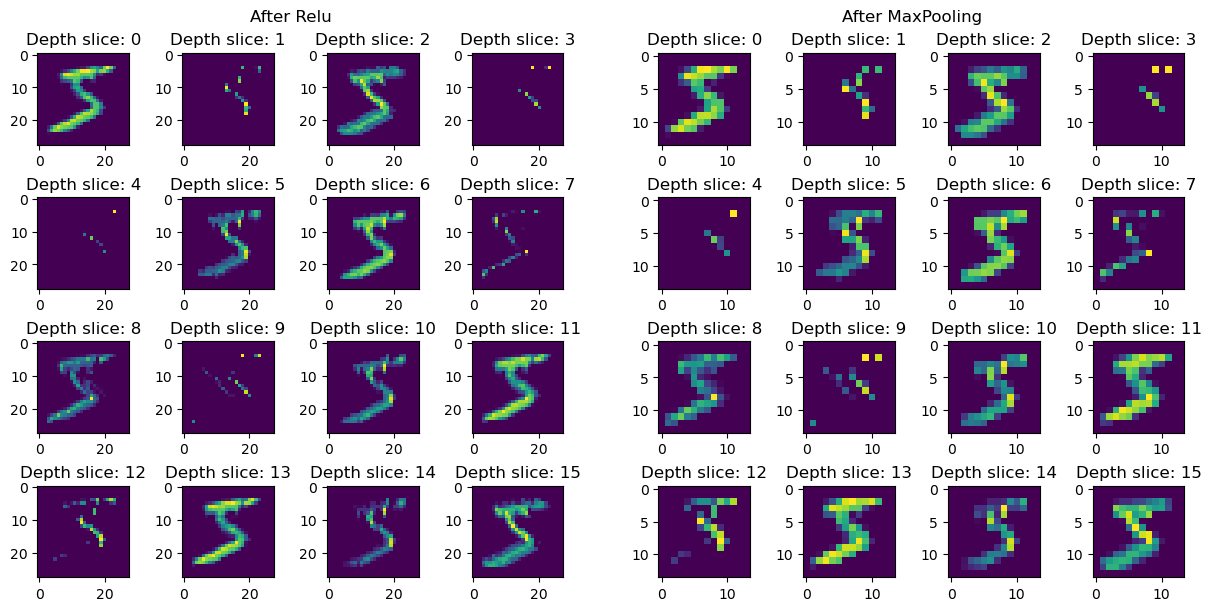

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
(subfig_left, subfig_right) = fig.subfigures(nrows=1, ncols=2, wspace=0.07)

relu_axs = subfig_left.subplots(nrows=4, ncols=4)
maxpool_axs = subfig_right.subplots(nrows=4, ncols=4)

for i, ax in enumerate(relu_axs.flatten()):
    ax.imshow(activation_output[0][:, :, i])
    ax.set_title(f"Depth slice: {i}") 

for i, ax in enumerate(maxpool_axs.flatten()):
    ax.imshow(maxpooled_output[0][:, :, i])
    ax.set_title(f"Depth slice: {i}") 


subfig_left.suptitle("After Relu")
subfig_right.suptitle("After MaxPooling")
plt.show()

## Building a CNN from scratch

In [522]:
glorot_initializer = tf.initializers.GlorotUniform(seed=42)

In [523]:
input_shape = X_train_shaped.shape[1:]
fc_neurons = 16
output_neurons = 10

In [524]:
filter_weights = tf.Variable(glorot_initializer([2, 2, 1, 8]), dtype=tf.float32)
filter_biases = tf.Variable(tf.zeros([8]), dtype=tf.float32)

# After maxpooling (2,2 ) with strides (2, 2) with -> the Fully Connected Layer weights
fc_hidden_weights = tf.Variable(glorot_initializer([input_shape[0]//2 * input_shape[1]//2 * filter_weights.shape[-1], fc_neurons]), dtype=tf.float32)
fc_hidden_biases = tf.Variable(tf.zeros([fc_neurons]), dtype=tf.float32)

fc_output_weights = tf.Variable(glorot_initializer([fc_neurons, output_neurons]), dtype=tf.float32)
fc_output_biases = tf.Variable(tf.zeros([output_neurons,]), dtype=tf.float32)

In [525]:
fc_weights = [fc_hidden_weights, fc_output_weights]
fc_biases = [fc_hidden_biases, fc_output_biases]

In [526]:
@tf.function
def forward_pass(input, filter_weights, filter_biases, fc_weights, fc_biases):
    """ Forward pass
    Args:
        input: Input features
        weight: Weights
        bias: Biases
    Returns:
        Softmax of (matmul+bias) layer output
    """
    conv_output = tf.nn.conv2d(
    input=input,
    filters=filter_weights,
    strides=[1, 1, 1, 1],
    padding="SAME",
    dilations=[1]
    )

    activation_output = tf.nn.relu(tf.nn.bias_add(conv_output, filter_biases))

    maxpooled_output = tf.nn.max_pool2d(activation_output,
                    ksize=(2, 2),
                    strides=(2, 2),
                    padding="SAME")
    
    maxpooled_output = tf.reshape(maxpooled_output, tf.stack([-1, tf.reduce_prod(tf.shape(maxpooled_output)[1:])]))

    hidden_output = tf.nn.relu(tf.matmul(maxpooled_output, fc_weights[0]) + fc_biases[0])
    
    return tf.nn.softmax(tf.matmul(hidden_output, fc_weights[1]) + fc_biases[1])

In [527]:
@tf.function
def loss_fn(y_true, y_pred):
    #return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred))
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred))

In [528]:
def accuracy_fn(y_true, y_pred):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [529]:
@tf.function
def train_step(inputs, targets, layers, biases, optimizer):
    with tf.GradientTape() as tape:
        predictions = forward_pass(inputs, filter_weights, filter_biases, fc_weights, fc_biases)
        loss = loss_fn(targets, predictions)
    
    gradients = tape.gradient(loss, layers+biases)
    optimizer.apply_gradients(zip(gradients, layers+biases))
    
    return loss

In [530]:
epochs = 20
batch_size = 16
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [531]:
losses = []
accuracies = []
best_test_accuracy = 0
for epoch in range(epochs):
    for step in range(0, len(X_train_shaped), batch_size):
        x_batch = X_train_shaped[step:step + batch_size]
        y_batch = y_train_original[step:step + batch_size]
        loss = train_step(x_batch, y_batch, [filter_weights] + fc_weights, [filter_biases] + fc_biases, optimizer)
    
    test_predictions =  forward_pass(X_test_shaped, filter_weights, filter_biases, fc_weights, fc_biases)
    val_accuracy = accuracy_fn(y_test, test_predictions)
    if val_accuracy > best_test_accuracy:
        best_val_accuracy = val_accuracy
    print(f"Epoch {epoch}, loss: {loss}, validation accuracy: {val_accuracy}")
    losses.append(loss)
    accuracies.append(val_accuracy)

Epoch 0, loss: 0.13250195980072021, validation accuracy: 0.8955000042915344
Epoch 1, loss: 0.06432411074638367, validation accuracy: 0.9132000207901001
Epoch 2, loss: 0.04486297443509102, validation accuracy: 0.9222999811172485
Epoch 3, loss: 0.03476935997605324, validation accuracy: 0.9282000064849854
Epoch 4, loss: 0.028315795585513115, validation accuracy: 0.9348000288009644
Epoch 5, loss: 0.023588959127664566, validation accuracy: 0.9394000172615051
Epoch 6, loss: 0.02051232010126114, validation accuracy: 0.9442999958992004
Epoch 7, loss: 0.01800357550382614, validation accuracy: 0.9490000009536743
Epoch 8, loss: 0.01587728224694729, validation accuracy: 0.9523000121116638
Epoch 9, loss: 0.014026268385350704, validation accuracy: 0.954800009727478
Epoch 10, loss: 0.012467915192246437, validation accuracy: 0.9573000073432922
Epoch 11, loss: 0.011114135384559631, validation accuracy: 0.960099995136261
Epoch 12, loss: 0.009970536455512047, validation accuracy: 0.9624000191688538
Epoch

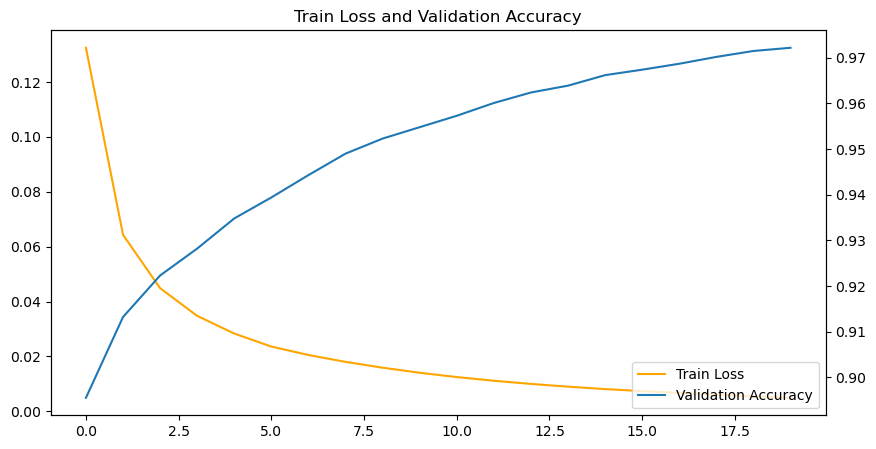

In [541]:
fig, ax = plt.subplots(figsize=(10,5))

ax2 = ax.twinx()

train_loss_line = ax.plot(losses, c="orange", label="Train Loss")
val_acc_line = ax2.plot(accuracies, label="Validation Accuracy")
lns = train_loss_line + val_acc_line
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=4)
plt.title("Train Loss and Validation Accuracy")
plt.show()

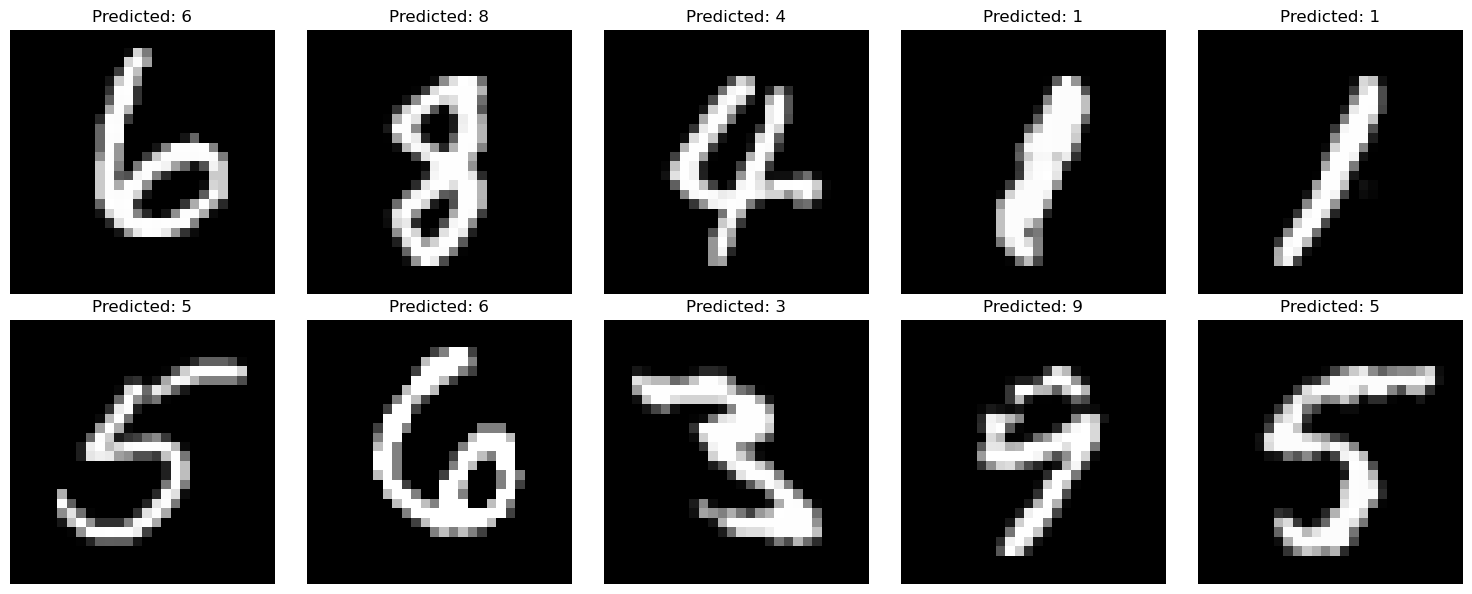

In [543]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

random_indices = np.random.randint(0, len(X_test), 10)

for idx, ax in zip(random_indices, axes.flat):
    ax.imshow(X_test[idx], cmap="gray")
    ax.set_title(f"Predicted: {tf.argmax(test_predictions[idx]).numpy()}")
    ax.axis("off")

plt.tight_layout()
plt.show()


### Plot filters/weights from CNN at first layer

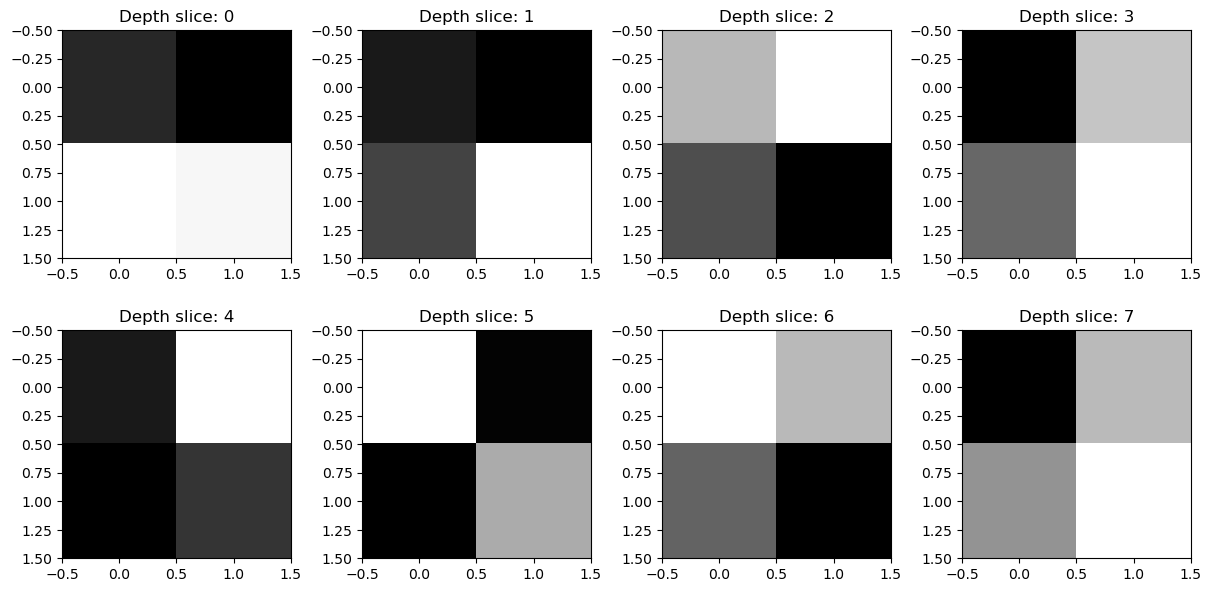

In [544]:
fig, axs = plt.subplots(nrows=2, ncols=4, constrained_layout=True, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(filter_weights[:, :, 0, i], cmap="grey")
    ax.set_title(f"Depth slice: {i}") 

plt.show()

In [594]:
convolved_train_images =  tf.nn.conv2d(
    input=X_train_shaped[0:10],
    filters=filter_weights,
    strides=[1, 1, 1, 1],
    padding="SAME",
    dilations=[1]
    )

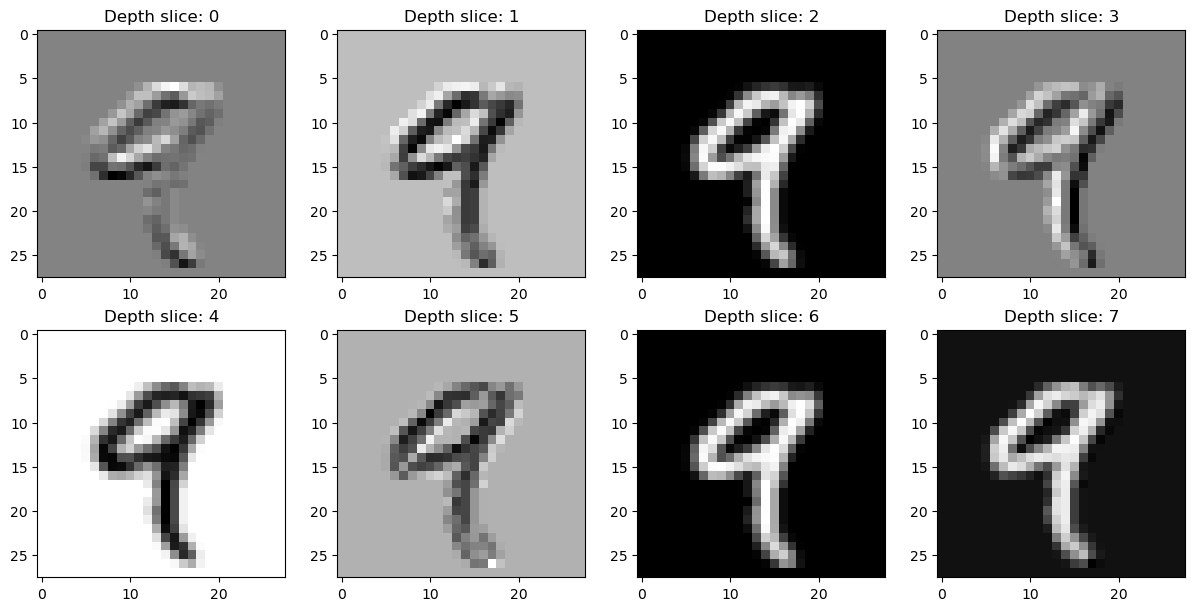

In [596]:
fig, axs = plt.subplots(nrows=2, ncols=4, constrained_layout=True, figsize=(12, 6))

random_idx = np.random.randint(0, 9, 1)

for i, ax in enumerate(axs.flatten()):
    ax.imshow(convolved_train_images[random_idx[0], :, :, i], cmap="grey")
    ax.set_title(f"Depth slice: {i}") 

plt.show()

## Cross Validation on 5 Stratified Fold

In [13]:
def create_layers_biases(input_shape, output_shape, shapes):
    glorot_initializer = tf.initializers.GlorotUniform(seed=42)

    weights = []
    biases = []
    num_of_conv_layers = 0

    for shape in shapes:
        if type(shape) == list:
            # Convolutional kernel/filter shape
            filter_weights = tf.Variable(glorot_initializer(shape), dtype=tf.float32)
            filter_biases = tf.Variable(tf.zeros([shape[-1], ]), dtype=tf.float32)

            weights.append(filter_weights)
            biases.append(filter_biases)
            num_of_conv_layers += 1

        else:
            # Fully connected layer shape
            # num_of_conv_layers if 2 and I will apply maxpool twice then input_shape/4
            fc_hidden_weights = tf.Variable(glorot_initializer([input_shape[0]//(num_of_conv_layers*2) * input_shape[1]//(num_of_conv_layers*2) * filter_weights.shape[-1], shape]), dtype=tf.float32)
            fc_hidden_biases = tf.Variable(tf.zeros([shape, ]), dtype=tf.float32)

            weights.append(fc_hidden_weights)
            biases.append(fc_hidden_biases)

    fc_output_weights = tf.Variable(glorot_initializer([shape, output_shape]), dtype=tf.float32)
    fc_output_biases = tf.Variable(tf.zeros([output_shape,]), dtype=tf.float32)

    weights.append(fc_output_weights)
    biases.append(fc_output_biases)

    return weights, biases

In [14]:
@tf.function
def forward_pass(input, weights, biases):
    """ Forward pass
    Args:
        input: Input features
        weight: Weights
        bias: Biases
    Returns:
        Softmax of (matmul+bias) layer output
    """

    for idx, (weight, bias) in enumerate(zip(weights, biases)):

        if len(weight.shape) == 4:
            # Conv Filter
            if idx == 0:
                x = tf.nn.conv2d(
                input=input,
                filters=weight,
                strides=[1, 1, 1, 1],
                padding="SAME",
                dilations=[1]
                )
            else:
                x = tf.nn.conv2d(
                input=x,
                filters=weight,
                strides=[1, 1, 1, 1],
                padding="SAME",
                dilations=[1]
                )  

            x = tf.nn.relu(tf.nn.bias_add(x, bias))

            x = tf.nn.max_pool2d(x,
                            ksize=(2, 2),
                            strides=(2, 2),
                            padding="SAME")
            
            if len(weights[idx + 1].shape) == 2:
            ## Flatten Part
                x = tf.reshape(x, tf.stack([-1, tf.reduce_prod(tf.shape(x)[1:])]))

        else:    
            if idx != len(weights) -1:      
                x = tf.nn.relu(tf.matmul(x, weight) + bias)
            else:
                x = tf.nn.softmax(tf.matmul(x, weight) + bias)
    
    return x

In [15]:
@tf.function
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred))

In [16]:
def accuracy_fn(y_true, y_pred):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [17]:
def train_model(X_train, y_train, X_test, y_test, output_shape, shapes, learning_rate, batch_size, epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    layers, biases = create_layers_biases(X_train.shape[1:], output_shape, shapes=shapes)
    
    @tf.function
    def train_step(inputs, targets, weights, biases, optimizer):
        with tf.GradientTape() as tape:
            predictions = forward_pass(inputs, weights, biases)
            loss = loss_fn(targets, predictions)
        
        gradients = tape.gradient(loss, weights+biases)
        optimizer.apply_gradients(zip(gradients, weights+biases))
        
        return loss

    best_test_accuracy = 0
    for epoch in range(epochs):
        for step in range(0, len(X_train), batch_size):
            x_batch = X_train[step:step + batch_size]
            y_batch = y_train[step:step + batch_size]
            loss = train_step(x_batch, y_batch, layers, biases, optimizer)
        
        test_predictions = forward_pass(X_test, layers, biases)
        val_accuracy = accuracy_fn(y_test, test_predictions)
        if val_accuracy > best_test_accuracy:
            best_val_accuracy = val_accuracy
        print(f"Epoch {epoch}, loss: {loss}, validation accuracy: {val_accuracy}")

    return best_val_accuracy

In [774]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [775]:
shapes_to_test = [[[2, 2, 1, 8], [2, 2, 1, 16], 16], [[2, 2, 1, 8], [2, 2, 1, 16], 32]]
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [16, 32]
epochs_list = [5, 10, 20]

In [776]:
params = product(shapes_to_test, learning_rates, batch_sizes, epochs_list)

In [ ]:
tried_params = []
accuracy_list = []
output_shape = 10

for param in params:
    shapes = param[0]
    lr = param[1]
    batch = param[2]
    epoch = param[3]

    accuracy_current_config = []

    for (train_index, test_index) in skf.split(X_train_shaped, y_train_original):

        X_train, y_train = tf.gather(X_train_shaped, train_index), y_train_original[train_index]
        X_val, y_val = tf.gather(X_train_shaped, test_index), y_train_original[test_index]

        val_accuracy = train_model(X_train, y_train, X_val, y_val, output_shape, shapes, lr, batch, epoch)
        accuracy_current_config.append(val_accuracy)
    
    accuracy_list.append(accuracy_current_config)
    tried_params.append(param)
    
    K.clear_session()
    print(f"LR: {lr}, Batch Size: {batch}, Epochs: {epoch}, Val Accuracy: {np.mean(accuracy_current_config):.4f}")

In [778]:
print(f"Best 5 fold mean accuracy: {round(np.max(np.mean(np.array(accuracy_list), axis=1)), 4)}")

Best 5 fold mean accuracy: 0.9746000170707703


In [784]:
best_params = tried_params[np.argmax(np.mean(np.array(accuracy_list), axis=1))]

## Predict on Test dataset

In [26]:
best_params  = ([[2, 2, 1, 8], [2, 2, 1, 16], 16], 0.001, 32, 20)

In [54]:
shapes = best_params[0]
lr = best_params[1]
batch_size = best_params[2]
epochs = best_params[3]
output_shape = 10


In [57]:
optimizer = tf.keras.optimizers.Adam()
layers, biases = create_layers_biases(X_train_shaped.shape[1:], output_shape, shapes=shapes)
losses = []

@tf.function
def train_step(inputs, targets, weights, biases, optimizer, learning_rate):
    with tf.GradientTape() as tape:
        predictions = forward_pass(inputs, weights, biases)
        loss = loss_fn(targets, predictions)
    
    gradients = tape.gradient(loss, weights+biases)
    optimizer.learning_rate = learning_rate
    optimizer.apply_gradients(zip(gradients, weights+biases))
    
    return loss

for epoch in range(epochs):
    # Learning rate scheduling based on epochs
    if epoch == 3:
        lr = lr * .1    
        
    for step in range(0, len(X_train_shaped), batch_size):
        x_batch = X_train_shaped[step:step + batch_size]
        y_batch = y_train_original[step:step + batch_size]
        loss = train_step(x_batch, y_batch, layers, biases, optimizer, lr)

    losses.append(loss)
    
    print(f"Epoch {epoch}, loss: {loss}")

Epoch 0, loss: 0.0693608894944191
Epoch 1, loss: 0.03584549203515053
Epoch 2, loss: 0.035703279078006744
Epoch 3, loss: 0.016432739794254303
Epoch 4, loss: 0.015686117112636566
Epoch 5, loss: 0.015275854617357254
Epoch 6, loss: 0.014899403788149357
Epoch 7, loss: 0.014682137407362461
Epoch 8, loss: 0.014492274262011051
Epoch 9, loss: 0.014328112825751305
Epoch 10, loss: 0.014178583398461342
Epoch 11, loss: 0.01401137188076973
Epoch 12, loss: 0.013844910077750683
Epoch 13, loss: 0.01375882513821125
Epoch 14, loss: 0.013636244460940361
Epoch 15, loss: 0.013455552980303764
Epoch 16, loss: 0.013217473402619362
Epoch 17, loss: 0.012949020601809025
Epoch 18, loss: 0.012739628553390503
Epoch 19, loss: 0.012594930827617645


### Plot filters/weights from CNN at first layer

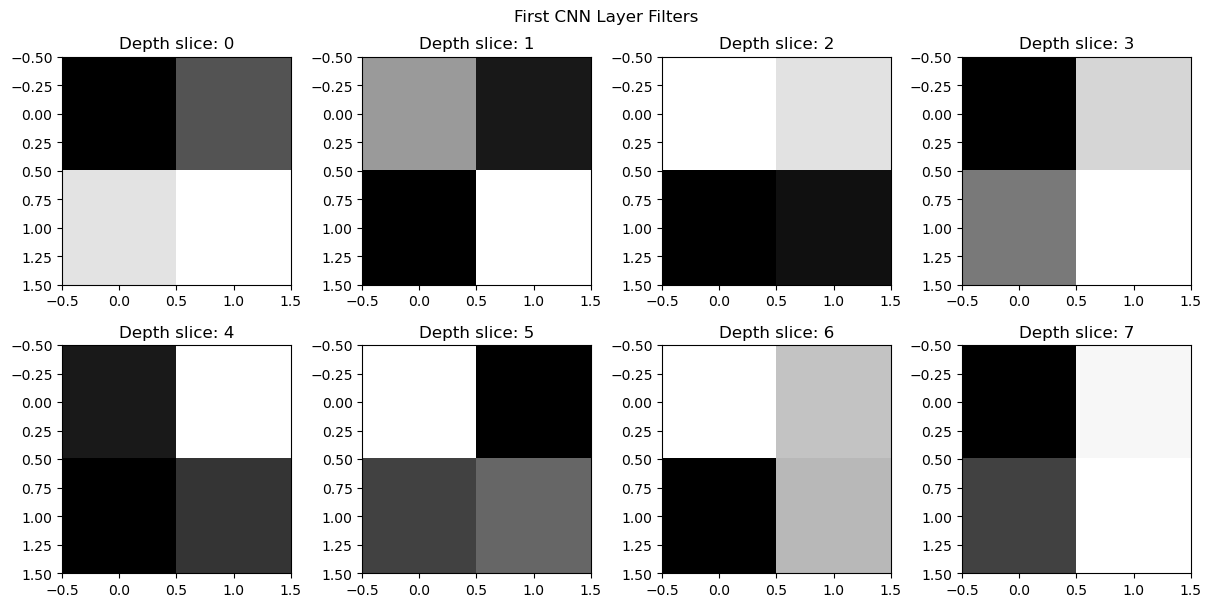

In [83]:
fig, axs = plt.subplots(nrows=2, ncols=4, constrained_layout=True, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(layers[0][:, :, 0, i], cmap="grey")
    ax.set_title(f"Depth slice: {i}") 

plt.suptitle("First CNN Layer Filters")
plt.show()

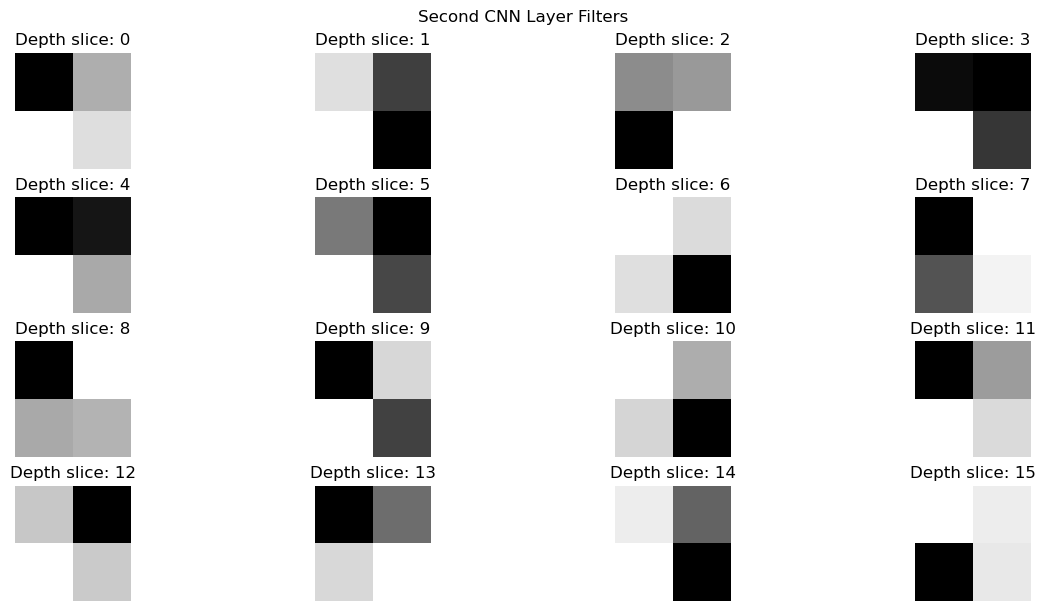

In [96]:
fig, axs = plt.subplots(nrows=4, ncols=4, constrained_layout=True, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(layers[1][:, :, 0, i], cmap="grey")
    ax.set_title(f"Depth slice: {i}") 
    ax.axis("off")

plt.suptitle("Second CNN Layer Filters")
plt.show()

In [125]:
convolved_train_images_first_cnn =  tf.nn.conv2d(
    input=X_train_shaped[0:10],
    filters=layers[0],
    strides=[1, 1, 1, 1],
    padding="SAME",
    dilations=[1]
    )

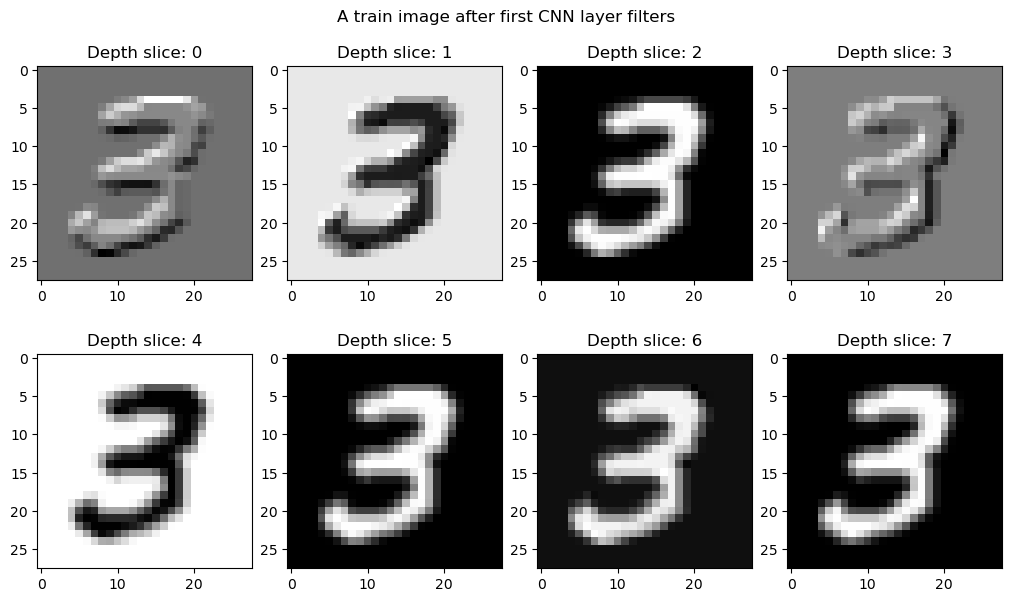

In [126]:
fig, axs = plt.subplots(nrows=2, ncols=4, constrained_layout=True, figsize=(10, 6))

random_idx = np.random.randint(0, 9, 1)

for i, ax in enumerate(axs.flatten()):
    ax.imshow(convolved_train_images_first_cnn[random_idx[0], :, :, i], cmap="grey")
    ax.set_title(f"Depth slice: {i}") 

plt.suptitle("A train image after first CNN layer filters")
plt.show()

In [ ]:
convolved_train_images_after_first_cnn = tf.nn.conv2d(
    input=convolved_train_images_first_cnn,
    filters=layers[1],
    strides=[1, 1, 1, 1],
    padding="SAME",
    dilations=[1]
    )

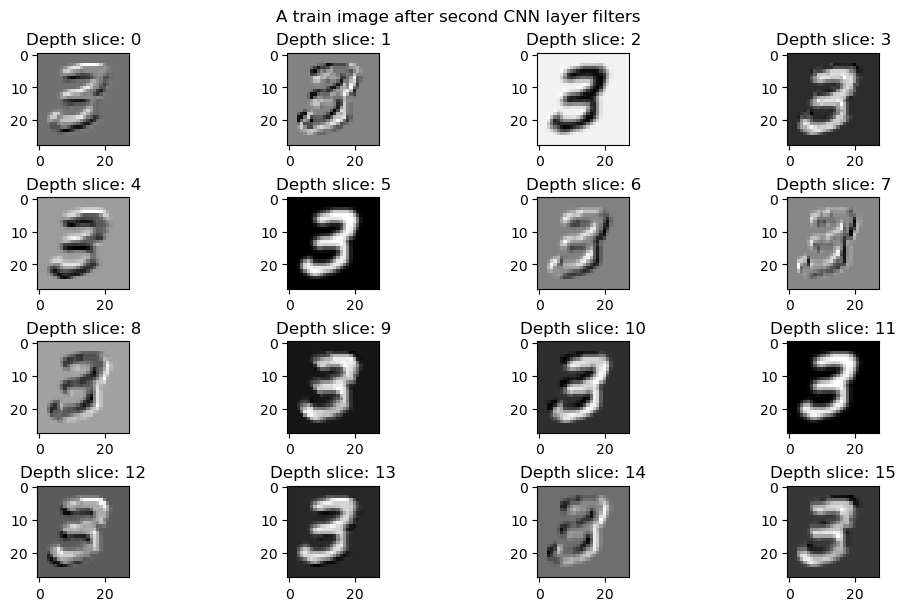

In [131]:
fig, axs = plt.subplots(nrows=4, ncols=4, constrained_layout=True, figsize=(10, 6))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(convolved_train_images_after_first_cnn[random_idx[0], :, :, i], cmap="grey")
    ax.set_title(f"Depth slice: {i}") 

plt.suptitle("A train image after second CNN layer filters")
plt.show()

In [132]:
predictions_test_set = forward_pass(X_test_shaped, layers, biases)

In [136]:
y_pred = tf.argmax(predictions_test_set, axis=1).numpy()

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

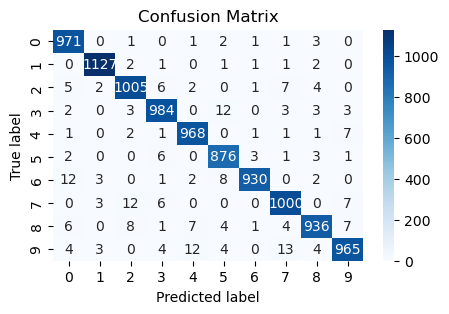

Validation Accuracy: 0.9762


In [137]:
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(f"Validation Accuracy: {accuracy:.4f}")

In [138]:
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
output_nodes = 10

for i in range(output_nodes):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")

print(f"\nMacro-average F1-score: {np.mean(f1_score):.4f}")

Class 0:
  Precision: 0.9681
  Recall: 0.9908
  F1-score: 0.9793
Class 1:
  Precision: 0.9903
  Recall: 0.9930
  F1-score: 0.9916
Class 2:
  Precision: 0.9729
  Recall: 0.9738
  F1-score: 0.9734
Class 3:
  Precision: 0.9743
  Recall: 0.9743
  F1-score: 0.9743
Class 4:
  Precision: 0.9758
  Recall: 0.9857
  F1-score: 0.9807
Class 5:
  Precision: 0.9658
  Recall: 0.9821
  F1-score: 0.9739
Class 6:
  Precision: 0.9915
  Recall: 0.9708
  F1-score: 0.9810
Class 7:
  Precision: 0.9699
  Recall: 0.9728
  F1-score: 0.9713
Class 8:
  Precision: 0.9770
  Recall: 0.9610
  F1-score: 0.9689
Class 9:
  Precision: 0.9747
  Recall: 0.9564
  F1-score: 0.9655

Macro-average F1-score: 0.9760


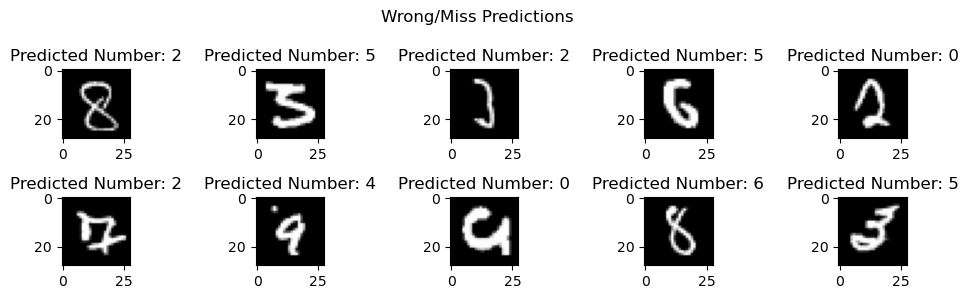

In [141]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 3))
plt.suptitle("Wrong/Miss Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(y_pred!=y_test)[0])
    image = X_test[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted Number: {y_pred[random_index]}")
    ax.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

# Summary 

The accuracy is 97.6% on test set, Macro-average F1-score: 0.9760!